<a href="https://colab.research.google.com/github/sftSalman/Image_segmentation/blob/main/VGG_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns

In [2]:
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU -O /tmp/fcnn-dataset.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /tmp/fcnn-dataset.zip
100% 126M/126M [00:02<00:00, 52.8MB/s]


In [3]:
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/fcnn')
zip_ref.close()

In [12]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

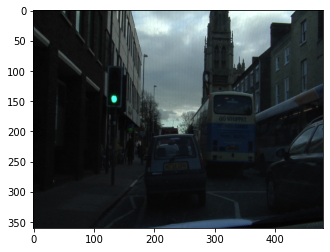

In [5]:
image = plt.imread("/content/fcnn/dataset1/images_prepped_train/0001TP_006690.png")
plt.imshow(image)

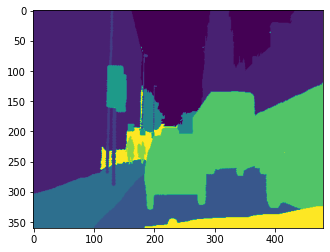

In [6]:
image = plt.imread("/content/fcnn/dataset1/annotations_prepped_train/0001TP_006690.png")
plt.imshow(image)

# In this funciton We will performe 3 task 
1 Convert image into tensor 
2 Resize image and segmention mask
3 Reshape the segmention mask 
4 Normalize pixels in the input image 

In [38]:
# def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  

#   img_raw = tf.io.read_file(t_filename)
#   annot_raw = tf.io.read_file(a_filename)

#   image = tf.image.decode_jpeg(img_raw)
#   annotation = tf.image.decode_jpeg(annot_raw)

#   image = tf.image.resize(image,(height,width,))
#   annotation = tf.image.resize(annotation,(height,width,))
#   image = tf.reshape(image,(height,width,3,))
#   annotation = tf.cast(annotation, dtype=tf.int32 )
#   annotation = tf.reshape(annotation,(height,width,1,))
#   stack_list = []

#   for c in range(len(class_names)):
#     mask = tf.equal(annotation[:,:,0], tf.constant(c))
#     stack_list.append(tf.cast(mask,dtype=tf.int32))
#     annotation = tf.stack(stack_list,axis =2)

#   image = image/127.5
#   image -= 1

  # return image ,annotation


In [44]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  """
  Preprocess the dataset by:
    * resizing the input image and the label map
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, (n_class)=12)
  
  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  """
  
  # convert image and the mask file to tensor
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)

  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape the segmentation mask
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  annotation = tf.stack(stack_list, axis=2) # or -1
  # print(annotation)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [45]:
# Utilities for preparing the datasets

BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

In [46]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/content/fcnn/dataset1/images_prepped_train','/content/fcnn/dataset1/annotations_prepped_train')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/content/fcnn/dataset1/images_prepped_test','/content/fcnn/dataset1/annotations_prepped_test')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)


In [47]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairrs
# the tuple values will mutiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f"{class_name} -- {color}")

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [48]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

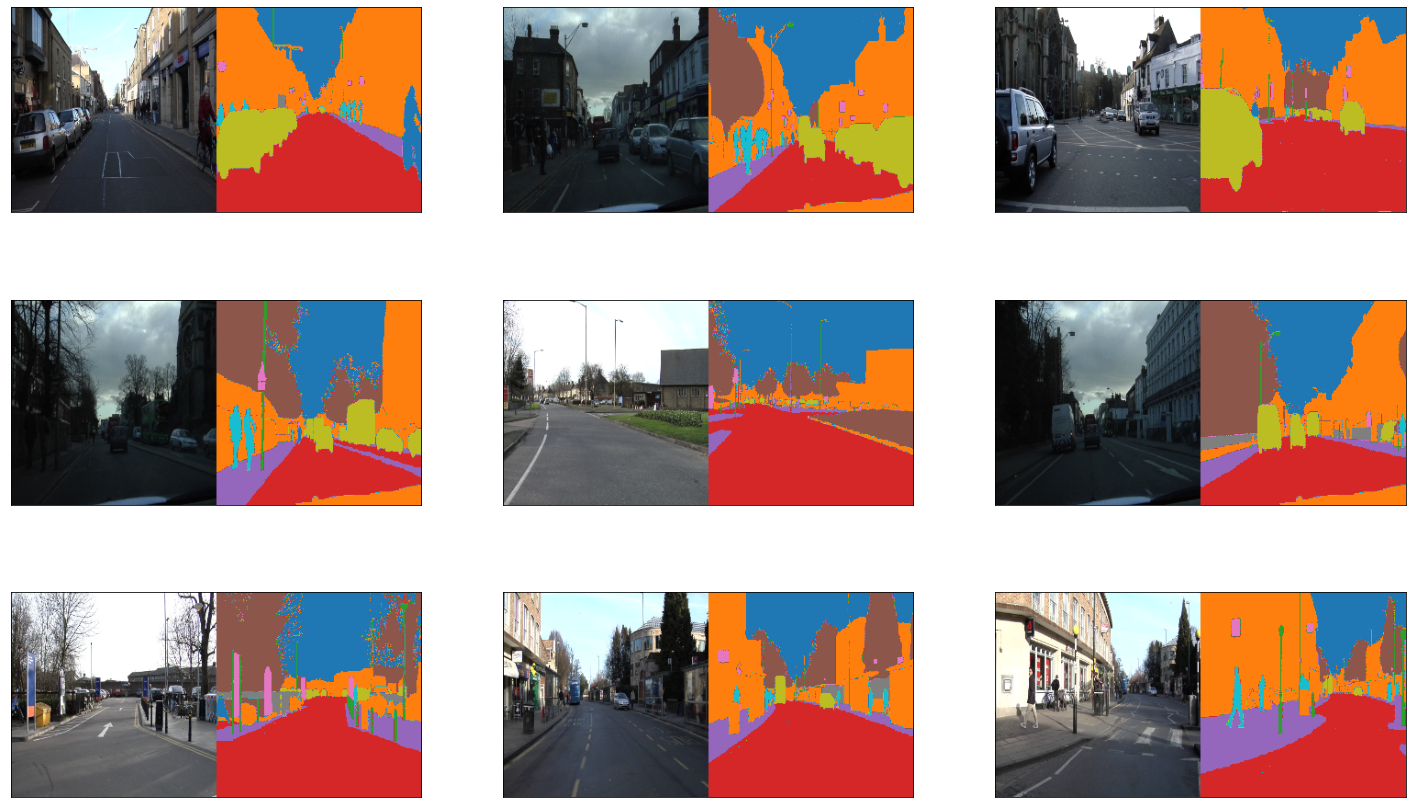

In [49]:
list_show_annotation(training_dataset)